In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

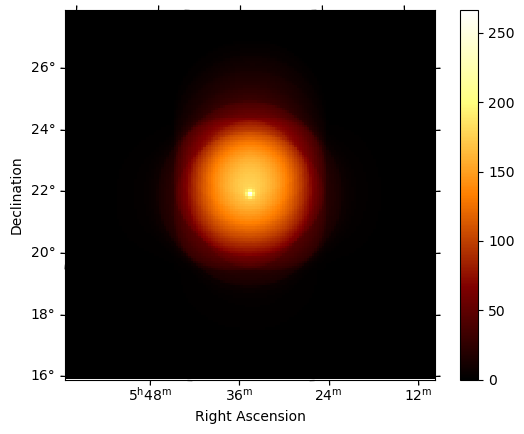

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1"
)

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Varying the Exposure

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

# energy independent method: pm 10% for reconstructed energy
shift_neg = -0.1 #-0.085
shift_pos = 0.1 #+0.085
shift_cor = 0.0

tilt_neg = -0.015 # 1e-24 for computational purposes -> covmatrix "1/0"
tilt_pos = 0.015
tilt_cor = 0.0

In [5]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

In [6]:
sys_d_cor = sys_dataset(dataset_asimov, shift_cor, tilt_cor, False)
dataset_cor_N = sys_d_cor.create_dataset_N()

sys_d_neg = sys_dataset(dataset_asimov, shift_neg, tilt_neg, False)
dataset_neg_N = sys_d_neg.create_dataset_N()

sys_d_pos = sys_dataset(dataset_asimov, shift_pos, tilt_pos, False)
dataset_pos_N = sys_d_pos.create_dataset_N()

zero = 1e-24
## additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift_neg**2, 1/tilt_neg**2, 1/zero**2, 1/zero**2])

dataset_pos_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_neg_N.penalising_invcovmatrix = penalising_invcovmatrix

datasets  = [dataset_pos_N, dataset_cor_N, dataset_neg_N]

#print(dataset_cor)

In [7]:
exposure_pos = dataset_pos_N.exposure
exposure_neg = dataset_neg_N.exposure

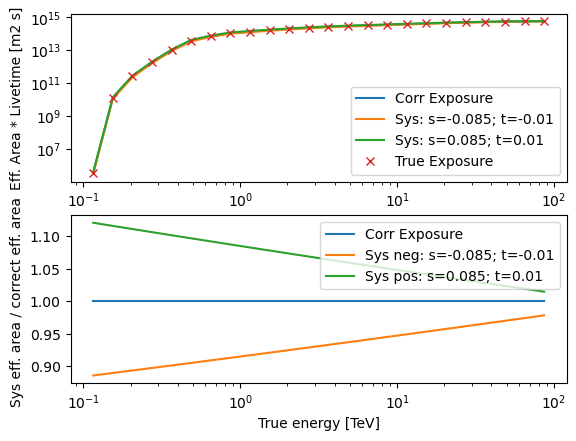

In [8]:
fig,ax = plt.subplots(2,1)

exposure_standard = dataset_asimov.exposure.data.sum(axis=2).sum(axis=1)
exposure_e = dataset_cor_N.exposure.data.sum(axis=2).sum(axis=1)

ax[0].plot(true_energy, exposure_e, label = "Corr Exposure")
ax[0].plot(true_energy, sum_e(exposure_neg.data), 
           label = f'Sys: s={shift_neg:.2}; t={tilt_neg:.2}')
ax[0].plot(true_energy, sum_e(exposure_pos.data), 
           label = f'Sys: s={shift_pos:.2}; t={tilt_pos:.2}')
ax[0].plot(true_energy, exposure_standard, 'x', label = "True Exposure")

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("True energy [TeV]")
ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_asimov.exposure.unit}]")
ax[0].legend()

ax[1].plot(true_energy, exposure_e/exposure_standard, label = "Corr Exposure")
ax[1].plot(true_energy, sum_e(exposure_neg.data)/exposure_e,
           label = f'Sys neg: s={shift_neg:.2}; t={tilt_neg:.2}')
ax[1].plot(true_energy, sum_e(exposure_pos.data)/ exposure_e, 
           label = f'Sys pos: s={shift_pos:.2}; t={tilt_pos:.2}')

#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("True energy [TeV]")
ax[1].set_ylabel(f"Sys eff. area / correct eff. area ")
ax[1].legend()

fig.savefig("plots/2c_exposure_example.pdf")

C:\Users\yt02izug\AppData\Local\Temp\ipykernel_1220\2802536242.py:23: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred/npred, label = "Model ")
C:\Users\yt02izug\AppData\Local\Temp\ipykernel_1220\2802536242.py:24: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_neg/npred,
C:\Users\yt02izug\AppData\Local\Temp\ipykernel_1220\2802536242.py:26: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_pos/npred,


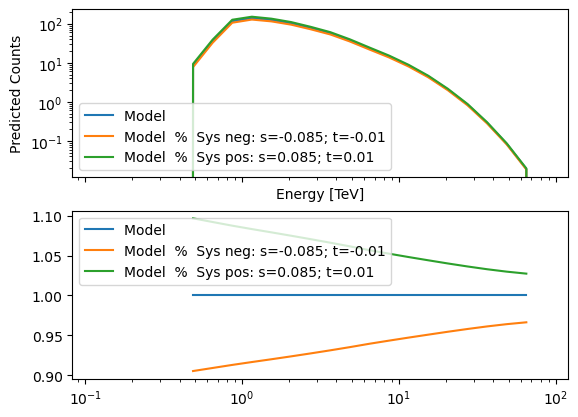

In [9]:
fig,ax = plt.subplots(2,1, sharex = True)

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred =     dataset_cor_N.npred_signal().data.sum(axis = 2).sum(axis= 1) #or (dataset_cor.counts - dataset_cor.background)
npred_neg = dataset_neg_N.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos_N.npred_signal().data.sum(axis = 2).sum(axis= 1)


ax[0].plot(true_energy, npred, label = "Model ")
ax[0].plot(true_energy, npred_neg, 
         label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.2}")
ax[0].plot(true_energy, npred_pos,  
         label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.2}")

         
ax[0].loglog()
ax[0].legend()
ax[0].set_xlabel("Energy [TeV]")
ax[0].set_ylabel("Predicted Counts")


ax[1].plot(true_energy, npred/npred, label = "Model ")
ax[1].plot(true_energy, npred_neg/npred, 
         label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.2}")
ax[1].plot(true_energy, npred_pos/npred,  
         label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.2}")

ax[1].legend()
ax[1].set_xscale('log')
fig = plt.gcf()
fig.savefig("plots/2c_counts.pdf")

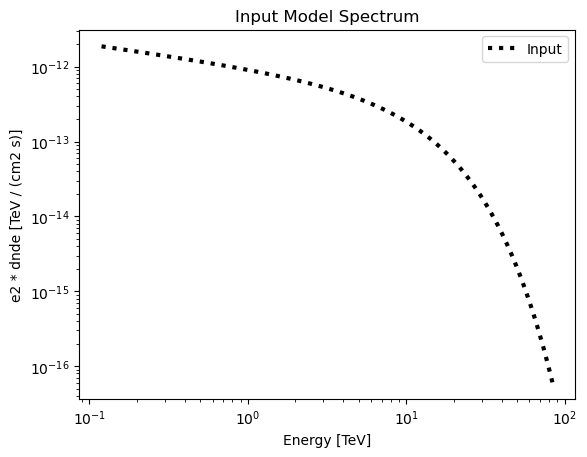

In [10]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_asimov.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

In [11]:
%%time
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.backend = "minuit"
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run([dataset_cor_N])

fit_neg = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_neg.backend = "minuit"
fit_neg.optimize_opts = minuit_opts
result_neg = fit_neg.run([dataset_neg_N])

fit_pos = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_pos.backend = "minuit"
fit_pos.optimize_opts = minuit_opts
result_pos = fit_pos.run([dataset_pos_N])
print(result_pos)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization terminated successfully.
	nfev       : 626
	total stat : -752490.76

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: total: 44min 20s
Wall time: 10min 54s


In [12]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]
print("Best Fit Amplitude")
amplitudes = []
m = dataset_asimov.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("Best Fit Index")
indices = []
m = dataset_asimov.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
print()   
    
print("Best Fit Lambda")
lambdas = []
value = dataset_asimov.models.parameters['lambda_'].value 
error = dataset_asimov.models.parameters['lambda_'].error
lambdas.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.models.parameters['lambda_'].value 
    error = d.models.parameters['lambda_'].error
    print(f'{value} pm {error}')
    lambdas.append((value, error))
    
    
with open('data/2c_norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/2c_amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/2c_indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
with open('data/2c_lambdas.yaml', 'w') as file:
    documents = yaml.dump(lambdas, file)
    
#dataset_neg_N.models.write("data/2c_model_neg.yml", overwrite= True)
#dataset_pos_N.models.write("data/2c_model_pos.yml", overwrite= True)
#dataset_cor_N.models.write("data/2c_model_cor.yml", overwrite= True)

Best Fit amplitude
====
Input
1e-12 pm 0
====
1.0958663524692213e-12 pm 1.7227645082009507e-13
1.0028393666347217e-12 pm 1.574658319985549e-13
9.251390798418713e-13 pm 1.452520606030911e-13

Best Fit Index
====
Input
2.3 pm 0
====
2.3185839018993577 pm 0.15840553752457157
2.309191357453889 pm 0.1578417928351445
2.296095500411978 pm 0.1578725189860709

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.000002684506471 pm 0.002066536503830845
1.0000023207097921 pm 0.002066542715862738
0.9999987228483876 pm 0.002066535733579333

Best Fit Lambda
====
Input
0.1 pm 0
====
0.1002606883027416 pm 0.04775946862362993
0.09841446518460482 pm 0.04731769306934572
0.09825011151339086 pm 0.04737233282308813


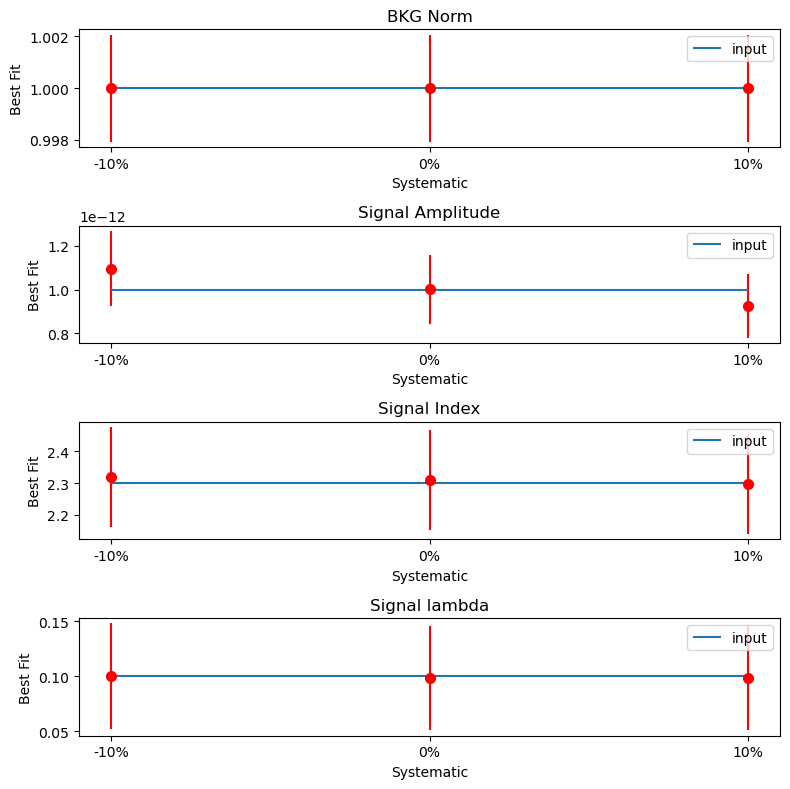

In [13]:
fig, axs = plt.subplots(4,1, figsize=(8,8))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal lambda")


labels = ['-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "Input")

for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[1].hlines( amplitudes[0][0], 1, 3, label = "Input")

for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[2].hlines( indices[0][0], 1, 3, label = "Input")

for i, a in enumerate(lambdas[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[3].hlines( lambdas[0][0], 1, 3, label = "Input")

plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/2c_nuisance_fit_parameters_standard.pdf")   


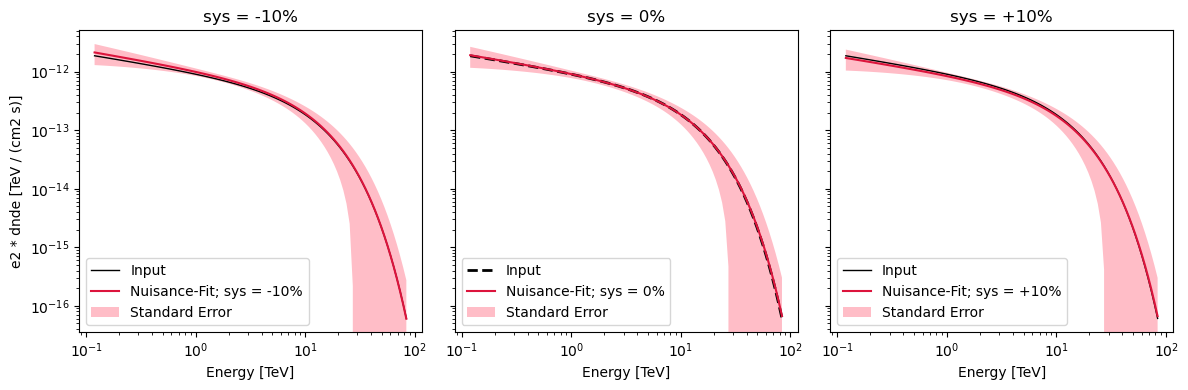

In [14]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Nuisance-Fit; sys = -10%", color = "crimson")
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Nuisance-Fit; sys = 0%", color = "crimson")
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Nuisance-Fit; sys = +10%", color = "crimson")
dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2c_spectrum_standard.pdf")

## Dependency of Errors on shift & tilt

### Varying Shift with Fixed Tilt

In [15]:
%%time
from numpy import savetxt, loadtxt

amplitude_shift = []
index_shift = []
lambda_shift = []
norm_shift = []
errors_amplitude_shift = []
errors_index_shift = []
errors_lambda_shift = []
errors_norm_shift = []

amplitude_shift_fail = []
index_shift_fail = []
lambda_shift_fail = []
norm_shift_fail = []
errors_amplitude_shift_fail = []
errors_index_shift_fail = []
errors_lambda_shift_fail = []
errors_norm_shift_fail = []

tilt_fixed = 1e-24

for i, shift in enumerate(np.linspace(-0.11, 0.11, 23)):
    if shift == 0:
        shift = 1e-24
    #print('shift', i, '=', shift)
    sys_d_cor = sys_dataset(dataset_asimov, shift, tilt_fixed, False)
    dataset_N = sys_d_cor.create_dataset_N()
    zero = 1e-24
    ## additional parameter bias and resolution (ereco) but are frozen
    penalising_invcovmatrix = np.zeros((4, 4))
    np.fill_diagonal(penalising_invcovmatrix,
                     [1/shift**2, 1/tilt_fixed**2, 1/zero**2, 1/zero**2])
    
    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_shift = dataset_N
    fit_shift = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_shift.backend = "minuit"
    fit_shift.optimize_opts = minuit_opts
    result_shift = fit_shift.run([dataset_shift])
    if result_shift.success:
        amplitude_shift.append((shift, dataset_shift.models.parameters['amplitude'].value))
        index_shift.append((shift, dataset_shift.models.parameters['index'].value))
        lambda_shift.append((shift, dataset_shift.models.parameters['lambda_'].value))
        norm_shift.append((shift, dataset_shift.models.parameters['norm'].value))

        errors_amplitude_shift.append((shift, dataset_shift.models.parameters['amplitude'].error))
        errors_index_shift.append((shift, dataset_shift.models.parameters['index'].error))
        errors_lambda_shift.append((shift, dataset_shift.models.parameters['lambda_'].error))
        errors_norm_shift.append((shift, dataset_shift.models.parameters['norm'].error))
    else:
        print(f'Fail {shift}')
        amplitude_shift_fail.append((shift, dataset_shift.models.parameters['amplitude'].value))
        index_shift_fail.append((shift, dataset_shift.models.parameters['index'].value))
        lambda_shift_fail.append((shift, dataset_shift.models.parameters['lambda_'].value))
        norm_shift_fail.append((shift, dataset_shift.models.parameters['norm'].value))

        errors_amplitude_shift_fail.append((shift, dataset_shift.models.parameters['amplitude'].error))
        errors_index_shift_fail.append((shift, dataset_shift.models.parameters['index'].error))
        errors_lambda_shift_fail.append((shift, dataset_shift.models.parameters['lambda_'].error))
        errors_norm_shift_fail.append((shift, dataset_shift.models.parameters['norm'].error))
    
    np.savetxt('data/2c_amplitude_shift_nuisance.txt', amplitude_shift)
    np.savetxt('data/2c_index_shift_nuisance.txt', index_shift)
    np.savetxt('data/2c_lambda_shift_nuisance.txt', lambda_shift)
    np.savetxt('data/2c_norm_shift_nuisance.txt', norm_shift)
    np.savetxt('data/2c_errors_amplitude_shift_nuisance.txt', errors_amplitude_shift)
    np.savetxt('data/2c_errors_index_shift_nuisance.txt', errors_index_shift)
    np.savetxt('data/2c_errors_lambda_shift_nuisance.txt', errors_lambda_shift)
    np.savetxt('data/2c_errors_norm_shift_nuisance.txt', errors_norm_shift)
               
    np.savetxt('data/2c_amplitude_shift_fail_nuisance.txt', amplitude_shift_fail)
    np.savetxt('data/2c_index_shift_fail_nuisance.txt', index_shift_fail)
    np.savetxt('data/2c_lambda_shift_fail_nuisance.txt', lambda_shift_fail)
    np.savetxt('data/2c_norm_shift_fail_nuisance.txt', norm_shift_fail)
    np.savetxt('data/2c_errors_amplitude_shift_fail_nuisance.txt', errors_amplitude_shift_fail)
    np.savetxt('data/2c_errors_index_shift_fail_nuisance.txt', errors_index_shift_fail)
    np.savetxt('data/2c_errors_lambda_shift_fail_nuisance.txt', errors_lambda_shift_fail)
    np.savetxt('data/2c_errors_norm_shift_fail_nuisance.txt', errors_norm_shift_fail)
    #print(dataset_shift.models.parameters['amplitude'].error)
    #print(dataset_shift.models.parameters['index'].error)

Fail -0.11
Fail -0.1
Fail -0.09
Fail -0.08
Fail -0.07
Fail -0.06
Fail -0.05
Fail -0.039999999999999994
Fail -0.03
Fail -0.020000000000000004
Fail -0.009999999999999995
Fail 1e-24
Fail 0.009999999999999995
Fail 0.020000000000000004
Fail 0.030000000000000013
Fail 0.039999999999999994
Fail 0.05
Fail 0.06000000000000001
Fail 0.06999999999999999
Fail 0.08
Fail 0.09000000000000001
Fail 0.09999999999999999
Fail 0.11
CPU times: total: 6h 9min 30s
Wall time: 1h 30min 25s


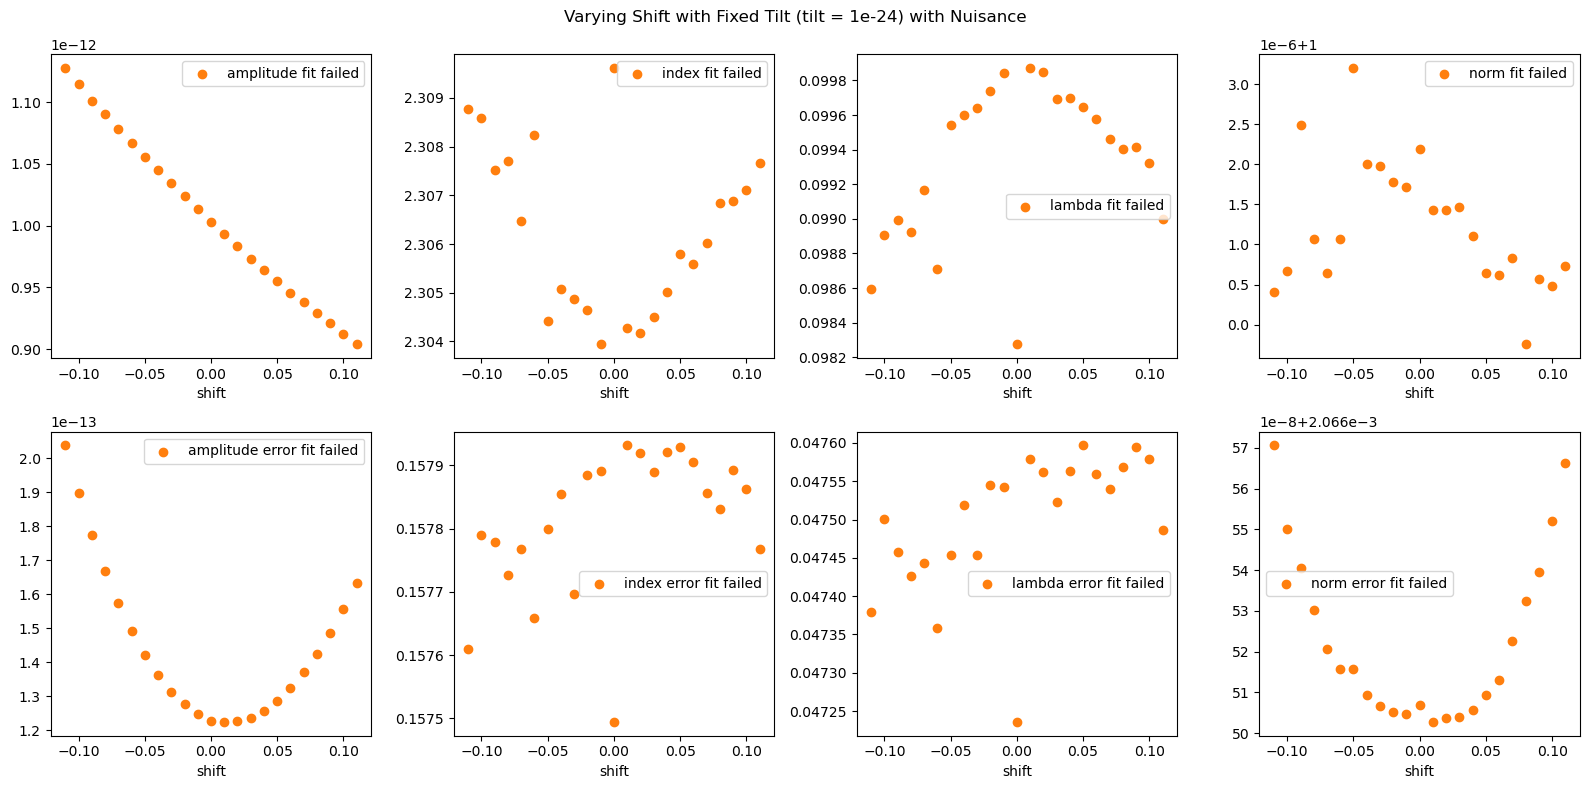

In [16]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

if bool(amplitude_shift):
    ax[0][0].scatter(*zip(*amplitude_shift), label='amplitude')  
    ax[0][1].scatter(*zip(*index_shift), label='index')
    ax[0][2].scatter(*zip(*lambda_shift), label='lambda')
    ax[0][3].scatter(*zip(*norm_shift), label='bkg norm')

    ax[1][0].scatter(*zip(*errors_amplitude_shift), label='amplitude error')  
    ax[1][1].scatter(*zip(*errors_index_shift), label='index error')
    ax[1][2].scatter(*zip(*errors_lambda_shift), label='lambda error')
    ax[1][3].scatter(*zip(*errors_norm_shift), label='bkg norm error')

if bool(amplitude_shift_fail):
    ax[0][0].scatter(*zip(*amplitude_shift_fail), label='amplitude fit failed', color='tab:orange')  
    ax[0][1].scatter(*zip(*index_shift_fail), label='index fit failed', color='tab:orange')
    ax[0][2].scatter(*zip(*lambda_shift_fail), label='lambda fit failed', color='tab:orange')
    ax[0][3].scatter(*zip(*norm_shift_fail), label='norm fit failed', color='tab:orange')

    ax[1][0].scatter(*zip(*errors_amplitude_shift_fail), label='amplitude error fit failed', color='tab:orange')  
    ax[1][1].scatter(*zip(*errors_index_shift_fail), label='index error fit failed', color='tab:orange')
    ax[1][2].scatter(*zip(*errors_lambda_shift_fail), label='lambda error fit failed', color='tab:orange')
    ax[1][3].scatter(*zip(*errors_norm_shift_fail), label='norm error fit failed', color='tab:orange')

ax[0][0].set_xlabel('shift');ax[0][1].set_xlabel('shift');ax[0][2].set_xlabel('shift');ax[0][3].set_xlabel('shift')
ax[1][0].set_xlabel('shift');ax[1][1].set_xlabel('shift');ax[1][2].set_xlabel('shift');ax[1][3].set_xlabel('shift')
ax[0][0].legend();ax[0][1].legend();ax[0][2].legend();ax[0][3].legend()
ax[1][0].legend();ax[1][1].legend();ax[1][2].legend();ax[1][3].legend()
plt.suptitle(f'Varying Shift with Fixed Tilt (tilt = {tilt_fixed}) with Nuisance')
plt.tight_layout()
plt.show()
fig.savefig("plots/2c_varying_shift_nuisance.pdf") 

### Varying Tilt with Fixed Shift

In [17]:
%%time
amplitude_tilt = []
index_tilt = []
lambda_tilt = []
norm_tilt = []
errors_amplitude_tilt = []
errors_index_tilt = []
errors_lambda_tilt = []
errors_norm_tilt = []

amplitude_tilt_fail = []
index_tilt_fail = []
lambda_tilt_fail = []
norm_tilt_fail = []
errors_amplitude_tilt_fail = []
errors_index_tilt_fail = []
errors_lambda_tilt_fail = []
errors_norm_tilt_fail = []

shift_fixed = -0.085

for i, tilt in enumerate(np.linspace(-0.025, 0.025, 25)): #np.linspace(-0.11, 0.11, 45)
    if tilt == 0:
        tilt = 1e-24
    #print('tilt', i, '=', tilt)
    sys_d_cor = sys_dataset(dataset_asimov, shift_fixed, tilt, False)
    dataset_N = sys_d_cor.create_dataset_N()
    zero = 1e-24
    ## additional parameter bias and resolution (ereco) but are frozen
    penalising_invcovmatrix = np.zeros((4, 4))
    np.fill_diagonal(penalising_invcovmatrix,
                     [1/shift_fixed**2, 1/tilt**2, 1/zero**2, 1/zero**2])
    
    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_tilt = dataset_N
    
    fit_tilt = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_tilt.backend = "minuit"
    fit_tilt.optimize_opts = minuit_opts
    result_tilt = fit_tilt.run([dataset_tilt])
    if result_tilt.success:
        #print(result_tilt.success)
        amplitude_tilt.append((tilt, dataset_tilt.models.parameters['amplitude'].value))
        index_tilt.append((tilt, dataset_tilt.models.parameters['index'].value))
        lambda_tilt.append((tilt, dataset_tilt.models.parameters['lambda_'].value))
        norm_tilt.append((tilt, dataset_tilt.models.parameters['norm'].value))

        errors_amplitude_tilt.append((tilt, dataset_tilt.models.parameters['amplitude'].error))
        errors_index_tilt.append((tilt, dataset_tilt.models.parameters['index'].error))
        errors_lambda_tilt.append((tilt, dataset_tilt.models.parameters['lambda_'].error))
        errors_norm_tilt.append((tilt, dataset_tilt.models.parameters['norm'].error))
    else:
        print(f'Fail {tilt}')
        amplitude_tilt_fail.append((tilt, dataset_tilt.models.parameters['amplitude'].value))
        index_tilt_fail.append((tilt, dataset_tilt.models.parameters['index'].value))
        lambda_tilt_fail.append((tilt, dataset_tilt.models.parameters['lambda_'].value))
        norm_tilt_fail.append((tilt, dataset_tilt.models.parameters['norm'].value))

        errors_amplitude_tilt_fail.append((tilt, dataset_tilt.models.parameters['amplitude'].error))
        errors_index_tilt_fail.append((tilt, dataset_tilt.models.parameters['index'].error))
        errors_lambda_tilt_fail.append((tilt, dataset_tilt.models.parameters['lambda_'].error))
        errors_norm_tilt_fail.append((tilt, dataset_tilt.models.parameters['norm'].error))
    
    np.savetxt('data/2c_amplitude_tilt_nuisance.txt', amplitude_tilt)
    np.savetxt('data/2c_index_tilt_nuisance.txt', index_tilt)
    np.savetxt('data/2c_lambda_tilt_nuisance.txt', lambda_tilt)
    np.savetxt('data/2c_norm_tilt_nuisance.txt', norm_tilt)
    np.savetxt('data/2c_errors_amplitude_tilt_nuisance.txt', errors_amplitude_tilt)
    np.savetxt('data/2c_errors_index_tilt_nuisance.txt', errors_index_tilt)
    np.savetxt('data/2c_errors_lambda_tilt_nuisance.txt', errors_lambda_tilt)
    np.savetxt('data/2c_errors_norm_tilt_nuisance.txt', errors_norm_tilt)
               
    np.savetxt('data/2c_amplitude_tilt_fail_nuisance.txt', amplitude_tilt_fail)
    np.savetxt('data/2c_index_tilt_fail_nuisance.txt', index_tilt_fail)
    np.savetxt('data/2c_lambda_tilt_fail_nuisance.txt', lambda_tilt_fail)
    np.savetxt('data/2c_norm_tilt_fail_nuisance.txt', norm_tilt_fail)
    np.savetxt('data/2c_errors_amplitude_tilt_fail_nuisance.txt', errors_amplitude_tilt_fail)
    np.savetxt('data/2c_errors_index_tilt_fail_nuisance.txt', errors_index_tilt_fail)
    np.savetxt('data/2c_errors_lambda_tilt_fail_nuisance.txt', errors_lambda_tilt_fail)
    np.savetxt('data/2c_errors_norm_tilt_fail_nuisance.txt', errors_norm_tilt_fail)
    #print(dataset_tilt.models.parameters['amplitude'].error)
    #print(dataset_tilt.models.parameters['index'].error)

Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
Fail 0.11
CPU times: total: 7h 45min 15s
Wall time: 2h 7min 42s


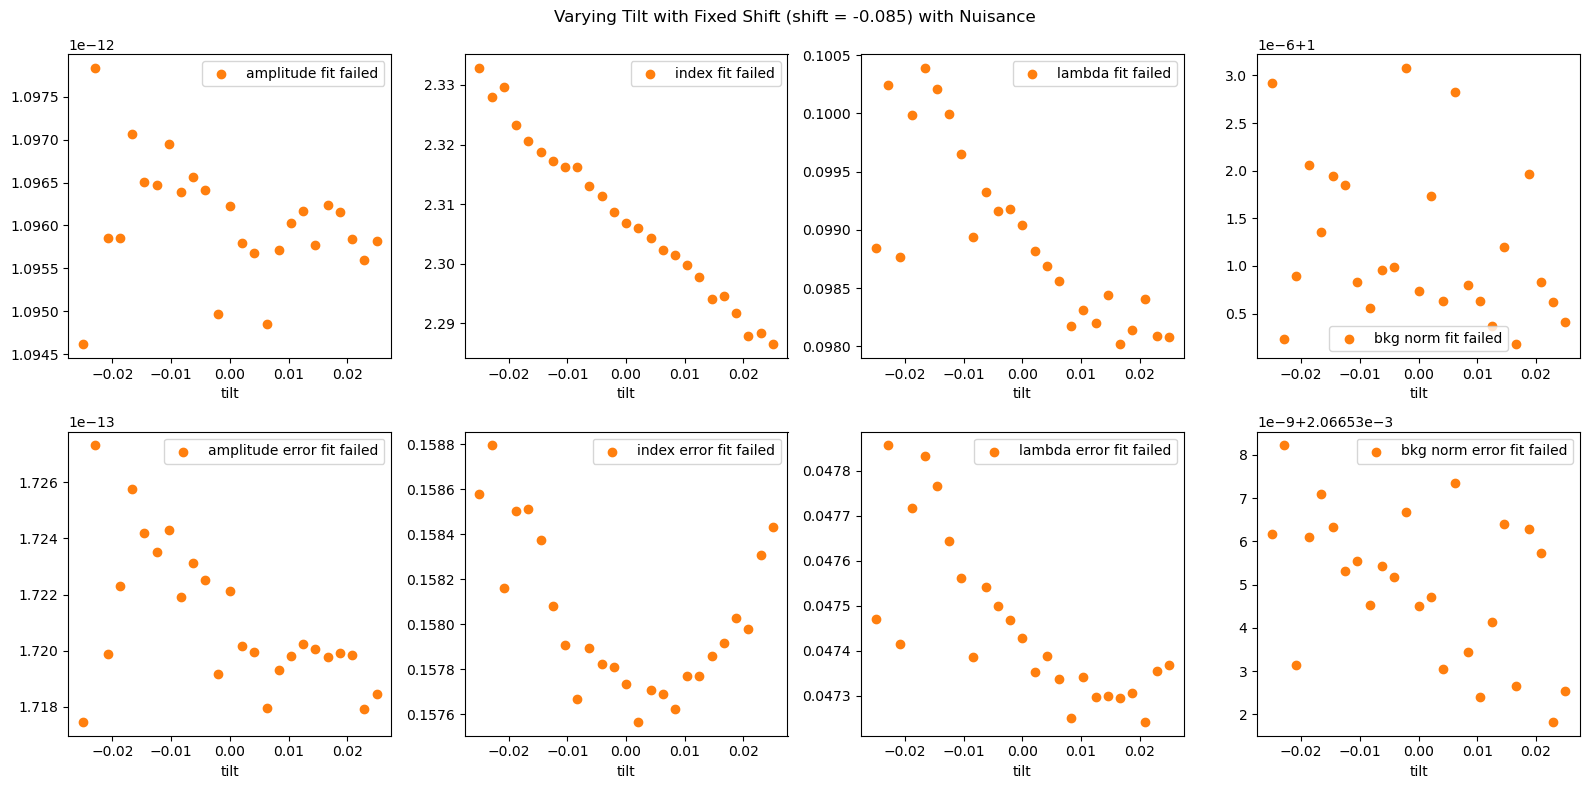

In [18]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

if bool(amplitude_tilt):
    ax[0][0].scatter(*zip(*amplitude_tilt), label='amplitude')  
    ax[0][1].scatter(*zip(*index_tilt), label='index')
    ax[0][2].scatter(*zip(*lambda_tilt), label='lambda')
    ax[0][3].scatter(*zip(*norm_tilt), label='bkg norm')

    ax[1][0].scatter(*zip(*errors_amplitude_tilt), label='amplitude error')  
    ax[1][1].scatter(*zip(*errors_index_tilt), label='index error')
    ax[1][2].scatter(*zip(*errors_lambda_tilt), label='lambda error')
    ax[1][3].scatter(*zip(*errors_norm_tilt), label='bkg norm error')

if bool(amplitude_tilt_fail):
    ax[0][0].scatter(*zip(*amplitude_tilt_fail), label='amplitude fit failed', color='tab:orange')  
    ax[0][1].scatter(*zip(*index_tilt_fail), label='index fit failed', color='tab:orange')
    ax[0][2].scatter(*zip(*lambda_tilt_fail), label='lambda fit failed', color='tab:orange')
    ax[0][3].scatter(*zip(*norm_tilt_fail), label='bkg norm fit failed', color='tab:orange')

    ax[1][0].scatter(*zip(*errors_amplitude_tilt_fail), label='amplitude error fit failed', color='tab:orange')  
    ax[1][1].scatter(*zip(*errors_index_tilt_fail), label='index error fit failed', color='tab:orange')
    ax[1][2].scatter(*zip(*errors_lambda_tilt_fail), label='lambda error fit failed', color='tab:orange')
    ax[1][3].scatter(*zip(*errors_norm_tilt_fail), label='bkg norm error fit failed', color='tab:orange')

ax[0][0].set_xlabel('tilt');ax[0][1].set_xlabel('tilt');ax[0][2].set_xlabel('tilt');ax[0][3].set_xlabel('tilt')
ax[1][0].set_xlabel('tilt');ax[1][1].set_xlabel('tilt');ax[1][2].set_xlabel('tilt');ax[1][3].set_xlabel('tilt')
ax[0][0].legend();ax[0][1].legend();ax[0][2].legend();ax[0][3].legend()
ax[1][0].legend();ax[1][1].legend();ax[1][2].legend();ax[1][3].legend()
plt.suptitle(f'Varying Tilt with Fixed Shift (shift = {shift_fixed}) with Nuisance')
plt.tight_layout()
fig.savefig("plots/2c_varying_tilt_nuisance.pdf") 
plt.show()

### Varying Shift and Tilt

In [19]:
np.linspace(-0.075, 0.075, 7)

array([-0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075])

In [7]:
%%time

compute = True

amplitude_3d = []
index_3d = []
lambda_3d = []
norm_3d = []
errors_amplitude_3d = []
errors_index_3d = []
errors_lambda_3d = []
errors_norm_3d = []

amplitude_3d_fail = []
index_3d_fail = []
lambda_3d_fail = []
norm_3d_fail = []
errors_amplitude_3d_fail = []
errors_index_3d_fail = []
errors_lambda_3d_fail = []
errors_norm_3d_fail = []

if compute:
    for i, shift in enumerate(np.linspace(-0.11, 0.11, 7)):
        if shift == 0:
            shift = 1e-24
        for j, tilt in enumerate(np.linspace(-0.020, 0.020, 7)):
            if tilt == 0:
                tilt = 1e-24
            #print(shift, tilt)
            sys_d_cor = sys_dataset(dataset_asimov, shift, tilt, False)
            dataset_N = sys_d_cor.create_dataset_N()
            zero = 1e-24
            ## additional parameter bias and resolution (ereco) but are frozen
            penalising_invcovmatrix = np.zeros((4, 4))
            np.fill_diagonal(penalising_invcovmatrix,
                             [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])

            dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
            dataset_3d = dataset_N
            
            fit = Fit(store_trace=False)
            minuit_opts = {"tol": 0.001, "strategy": 2}
            fit.backend = "minuit"
            fit.optimize_opts = minuit_opts
            result = fit.run([dataset_3d])
            
            if result.success:
                amplitude_3d.append((shift, tilt, dataset_3d.models.parameters['amplitude'].value))
                index_3d.append((shift, tilt, dataset_3d.models.parameters['index'].value))
                lambda_3d.append((shift, tilt, dataset_3d.models.parameters['lambda_'].value))
                norm_3d.append((shift, tilt, dataset_3d.models.parameters['norm'].value))

                errors_amplitude_3d.append((shift, tilt, dataset_3d.models.parameters['amplitude'].error))
                errors_index_3d.append((shift, tilt, dataset_3d.models.parameters['index'].error))
                errors_lambda_3d.append((shift, tilt, dataset_3d.models.parameters['lambda_'].error))
                errors_norm_3d.append((shift, tilt, dataset_3d.models.parameters['norm'].error))
            else:
                print(f'Fail {shift} {tilt}')
                amplitude_3d_fail.append((shift, tilt, dataset_3d.models.parameters['amplitude'].value))
                index_3d_fail.append((shift, tilt, dataset_3d.models.parameters['index'].value))
                lambda_3d_fail.append((shift, tilt, dataset_3d.models.parameters['lambda_'].value))
                norm_3d_fail.append((shift, tilt, dataset_3d.models.parameters['norm'].value))

                errors_amplitude_3d_fail.append((shift, tilt, dataset_3d.models.parameters['amplitude'].error))
                errors_index_3d_fail.append((shift, tilt, dataset_3d.models.parameters['index'].error))
                errors_lambda_3d_fail.append((shift, tilt, dataset_3d.models.parameters['lambda_'].error)) 
                errors_norm_3d_fail.append((shift, tilt, dataset_3d.models.parameters['norm'].error))
                
    np.savetxt('data/2c_amplitude_3d_nuisance.txt', amplitude_3d)
    np.savetxt('data/2c_index_3d_nuisance.txt', index_3d)
    np.savetxt('data/2c_lambda_3d_nuisance.txt', lambda_3d)
    np.savetxt('data/2c_norm_3d_nuisance.txt', norm_3d)
    np.savetxt('data/2c_errors_amplitude_3d_nuisance.txt', errors_amplitude_3d)
    np.savetxt('data/2c_errors_index_3d_nuisance.txt', errors_index_3d)
    np.savetxt('data/2c_errors_lambda_3d_nuisance.txt', errors_lambda_3d)
    np.savetxt('data/2c_errors_norm_3d_nuisance.txt', errors_norm_3d)
               
    np.savetxt('data/2c_amplitude_3d_fail_nuisance.txt', amplitude_3d_fail)
    np.savetxt('data/2c_index_3d_fail_nuisance.txt', index_3d_fail)
    np.savetxt('data/2c_lambda_3d_fail_nuisance.txt', lambda_3d_fail)
    np.savetxt('data/2c_norm_3d_fail_nuisance.txt', norm_3d_fail)
    np.savetxt('data/2c_errors_amplitude_3d_fail_nuisance.txt', errors_amplitude_3d_fail)
    np.savetxt('data/2c_errors_index_3d_fail_nuisance.txt', errors_index_3d_fail)
    np.savetxt('data/2c_errors_lambda_3d_fail_nuisance.txt', errors_lambda_3d_fail)
    np.savetxt('data/2c_errors_norm_3d_fail_nuisance.txt', errors_norm_3d_fail)
    
else:
    amplitude_3d = np.loadtxt('data/2c_amplitude_3d_nuisance.txt')
    index_3d = np.loadtxt('data/2c_index_3d_nuisance.txt')
    lambda_3d = np.loadtxt('data/2c_lambda_3d_nuisance.txt')
    norm_3d = np.loadtxt('data/2c_norm_3d_nuisance.txt')
    errors_amplitude_3d = np.loadtxt('data/2c_errors_amplitude_3d_nuisance.txt')
    errors_index_3d = np.loadtxt('data/2c_errors_index_3d_nuisance.txt')
    errors_lambda_3d = np.loadtxt('data/2c_errors_lambda_3d_nuisance.txt')
    errors_norm_3d = np.loadtxt('data/2c_errors_norm_3d_nuisance.txt')
               
    amplitude_3d_fail = np.loadtxt('data/2c_amplitude_3d_fail_nuisance.txt')
    index_3d_fail = np.loadtxt('data/2c_index_3d_fail_nuisance.txt')
    lambda_3d_fail = np.loadtxt('data/2c_lambda_3d_fail_nuisance.txt')
    norm_3d_fail = np.loadtxt('data/2c_norm_3d_fail_nuisance.txt')
    errors_amplitude_3d_fail = np.loadtxt('data/2c_errors_amplitude_3d_fail_nuisance.txt')
    errors_index_3d_fail = np.loadtxt('data/2c_errors_index_3d_fail_nuisance.txt')
    errors_lambda_3d_fail = np.loadtxt('data/2c_errors_lambda_3d_fail_nuisance.txt')
    errors_norm_3d_fail = np.loadtxt('data/2c_errors_norm_3d_fail_nuisance.txt')

Fail -0.11 -0.02
Fail -0.11 -0.013333333333333332
Fail -0.11 -0.006666666666666666
Fail -0.11 1e-24
Fail -0.11 0.006666666666666668
Fail -0.11 0.013333333333333332
Fail -0.11 0.02
Fail -0.07333333333333333 -0.02
Fail -0.07333333333333333 -0.013333333333333332
Fail -0.07333333333333333 -0.006666666666666666
Fail -0.07333333333333333 1e-24
Fail -0.07333333333333333 0.006666666666666668
Fail -0.07333333333333333 0.013333333333333332
Fail -0.03666666666666667 -0.02
Fail -0.03666666666666667 -0.013333333333333332
Fail -0.03666666666666667 -0.006666666666666666
Fail -0.03666666666666667 1e-24
Fail -0.03666666666666667 0.006666666666666668
Fail -0.03666666666666667 0.013333333333333332
Fail -0.03666666666666667 0.02
Fail 1e-24 -0.02
Fail 1e-24 -0.013333333333333332
Fail 1e-24 -0.006666666666666666
Fail 1e-24 1e-24
Fail 1e-24 0.006666666666666668
Fail 0.03666666666666667 -0.02
Fail 0.03666666666666667 -0.013333333333333332
Fail 0.03666666666666667 -0.006666666666666666
Fail 0.03666666666666667

In [21]:
print(errors_index_3d_fail)

[(-0.11, -0.02, 0.15844894482538568), (-0.11, -0.016, 0.15827479084922122), (-0.11, -0.012, 0.15808963941555185), (-0.11, -0.008, 0.15794208836386062), (-0.11, -0.004, 0.157825558242572), (-0.11, 1e-24, 0.1576094002680388), (-0.11, 0.004, 0.1577069836011506), (-0.11, 0.008, 0.15777388271328843), (-0.11, 0.012, 0.15798669322778292), (-0.11, 0.016000000000000004, 0.1579623976063717), (-0.11, 0.02, 0.15811919309743552), (-0.088, -0.02, 0.15862446553633386), (-0.088, -0.016, 0.15844899929933082), (-0.088, -0.012, 0.15805223455631046), (-0.088, -0.008, 0.15792704279106032), (-0.088, -0.004, 0.15787015419239092), (-0.088, 1e-24, 0.15760881183121547), (-0.088, 0.004, 0.1576805218726306), (-0.088, 0.008, 0.15771342290725915), (-0.088, 0.012, 0.1576151805697256), (-0.088, 0.016000000000000004, 0.1579017969297012), (-0.088, 0.02, 0.1581709919728258), (-0.066, -0.02, 0.15811601248094126), (-0.066, -0.016, 0.15846023531657744), (-0.066, -0.012, 0.15830566068525995), (-0.066, -0.004, 0.157878774317

<IPython.core.display.Javascript object>


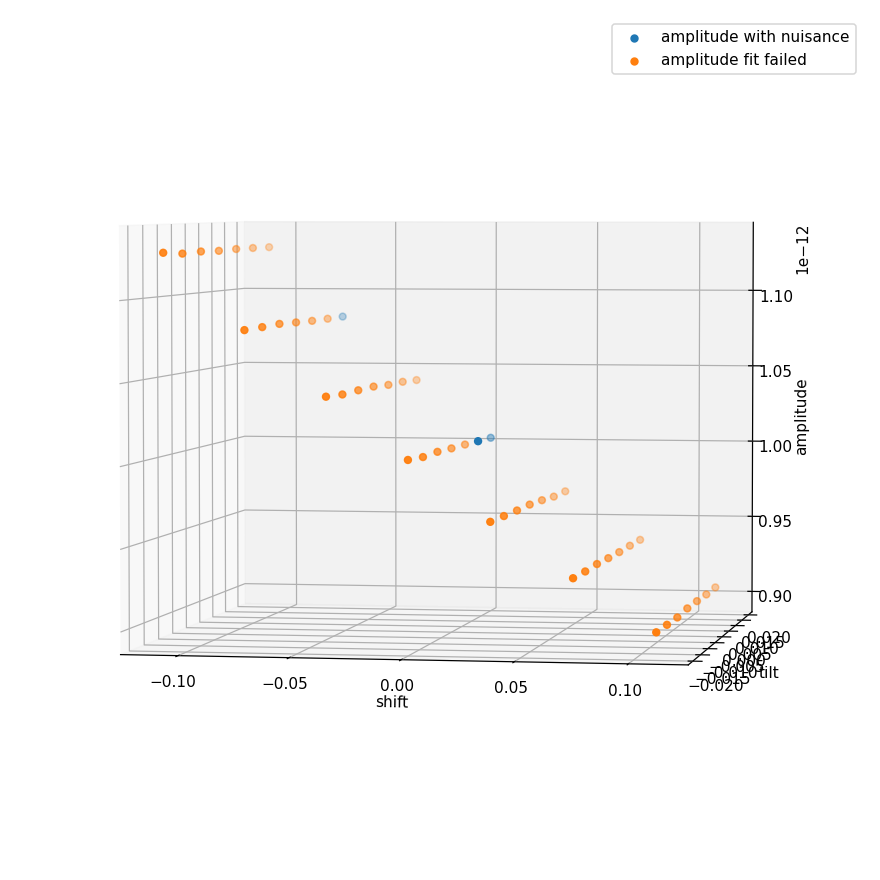

In [8]:
%matplotlib notebook
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')

if bool(errors_amplitude_3d):
    ax.scatter3D(*zip(*amplitude_3d), label='amplitude with nuisance') 
if bool(errors_amplitude_3d_fail):#errors_amplitude_3d_fail.size > 0:
    ax.scatter3D(*zip(*amplitude_3d_fail), label='amplitude fit failed', color='tab:orange') 
ax.view_init(3,280)
#ax.set_zlim3d(1.1e-13, 1.4e-13)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('amplitude')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_amplitude_nuisance.pdf") 
plt.show()

<IPython.core.display.Javascript object>


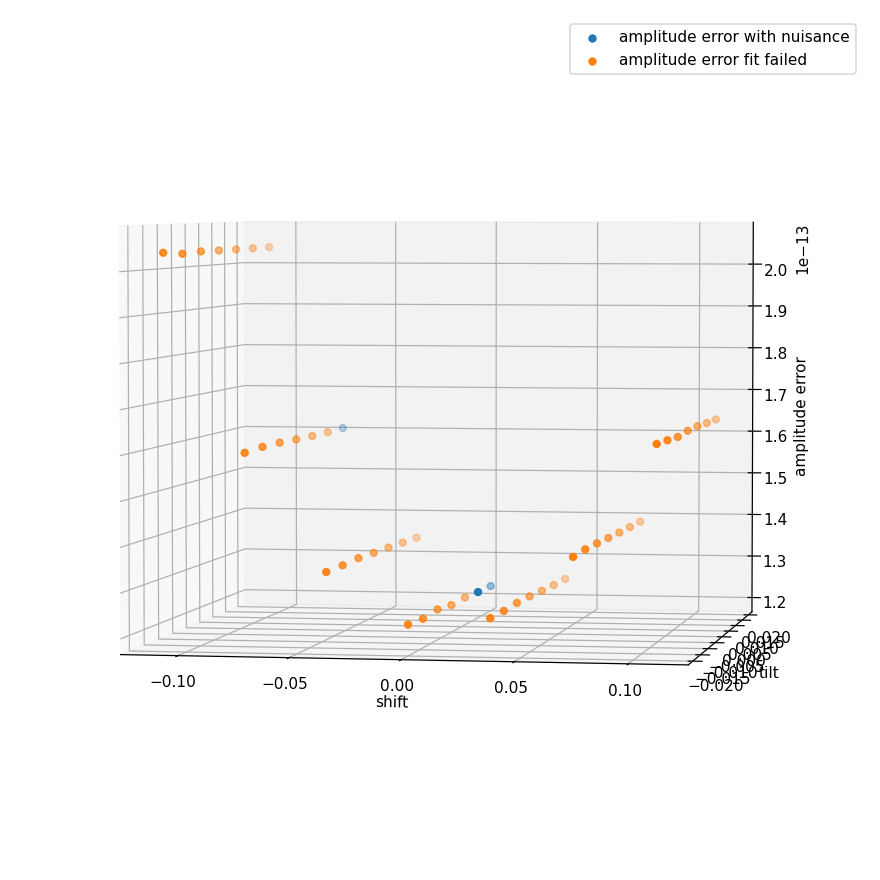

In [9]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')

if bool(errors_amplitude_3d):
    ax.scatter3D(*zip(*errors_amplitude_3d), label='amplitude error with nuisance') 
if bool(errors_amplitude_3d_fail):#errors_amplitude_3d_fail.size > 0:
    ax.scatter3D(*zip(*errors_amplitude_3d_fail), label='amplitude error fit failed', color='tab:orange') 
ax.view_init(3,280)
#ax.set_zlim3d(1.1e-13, 1.4e-13)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('amplitude error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_amplitude_error_nuisance.pdf") 
plt.show()

<IPython.core.display.Javascript object>


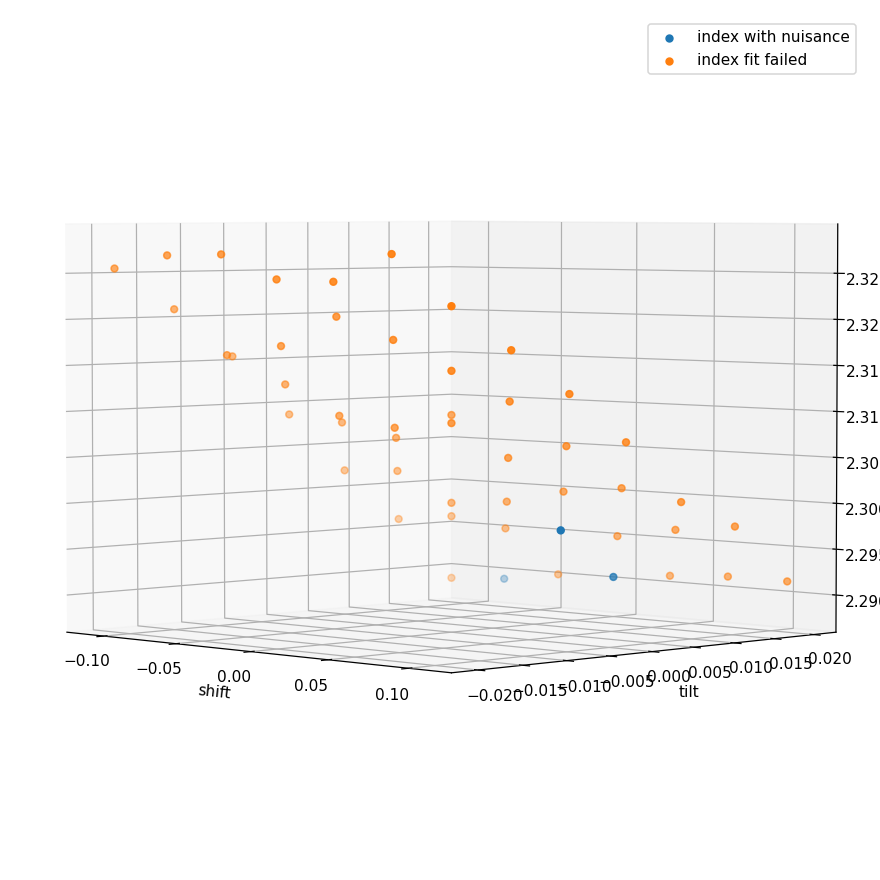

In [10]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_index_3d):
    ax.scatter3D(*zip(*index_3d), label='index with nuisance') 
if bool(errors_index_3d_fail): #errors_index_3d_fail.size > 0:
    ax.scatter3D(*zip(*index_3d_fail), label='index fit failed', color='tab:orange') 
ax.view_init(3,315)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('index')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_index_nuisance.pdf") 
plt.show()

<IPython.core.display.Javascript object>


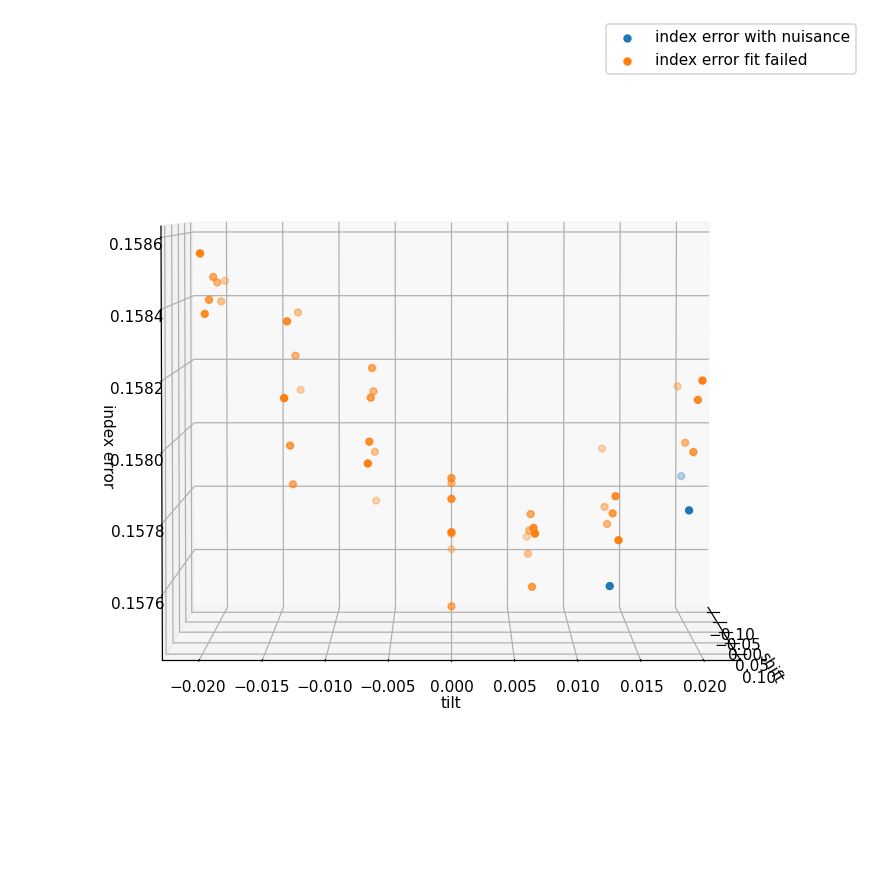

In [11]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_index_3d):
    ax.scatter3D(*zip(*errors_index_3d), label='index error with nuisance') 
if bool(errors_index_3d_fail):#errors_index_3d_fail.size > 0:
    ax.scatter3D(*zip(*errors_index_3d_fail), label='index error fit failed', color='tab:orange') 
ax.view_init(3,0)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('index error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_index_error_nuisance.pdf") 
plt.show()

<IPython.core.display.Javascript object>


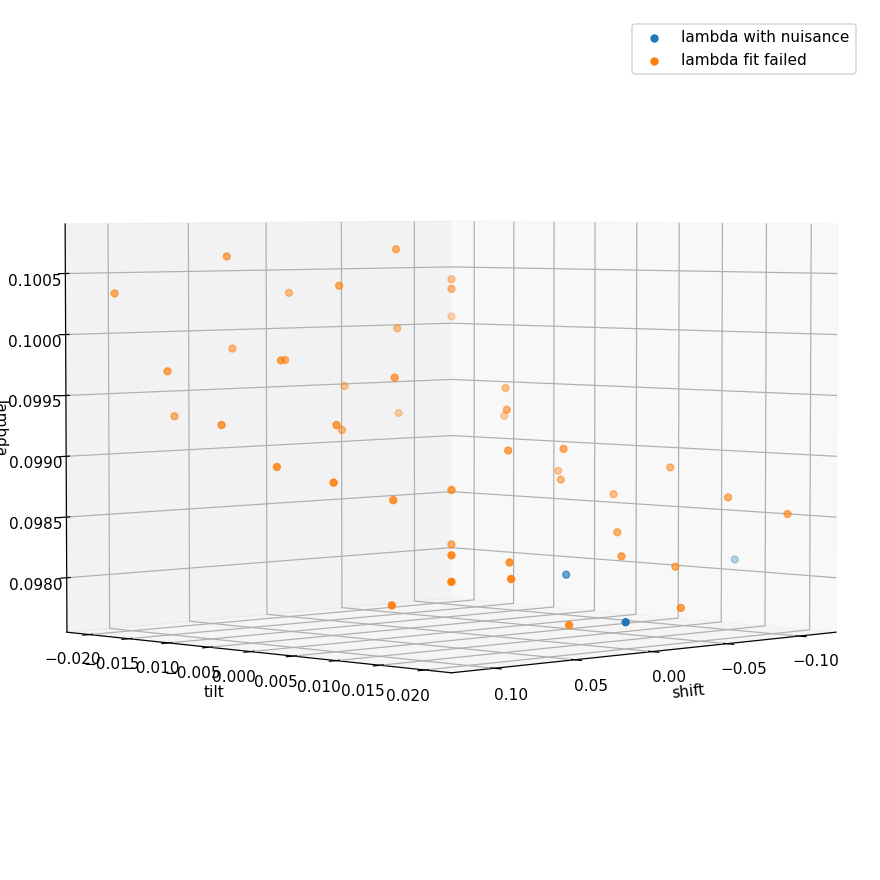

In [12]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_lambda_3d):
    ax.scatter3D(*zip(*lambda_3d), label='lambda with nuisance') 
if bool(errors_lambda_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*lambda_3d_fail), label='lambda fit failed', color='tab:orange')
ax.view_init(3,45)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('lambda')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_lambda_nuisance.pdf") 
plt.show()

<IPython.core.display.Javascript object>


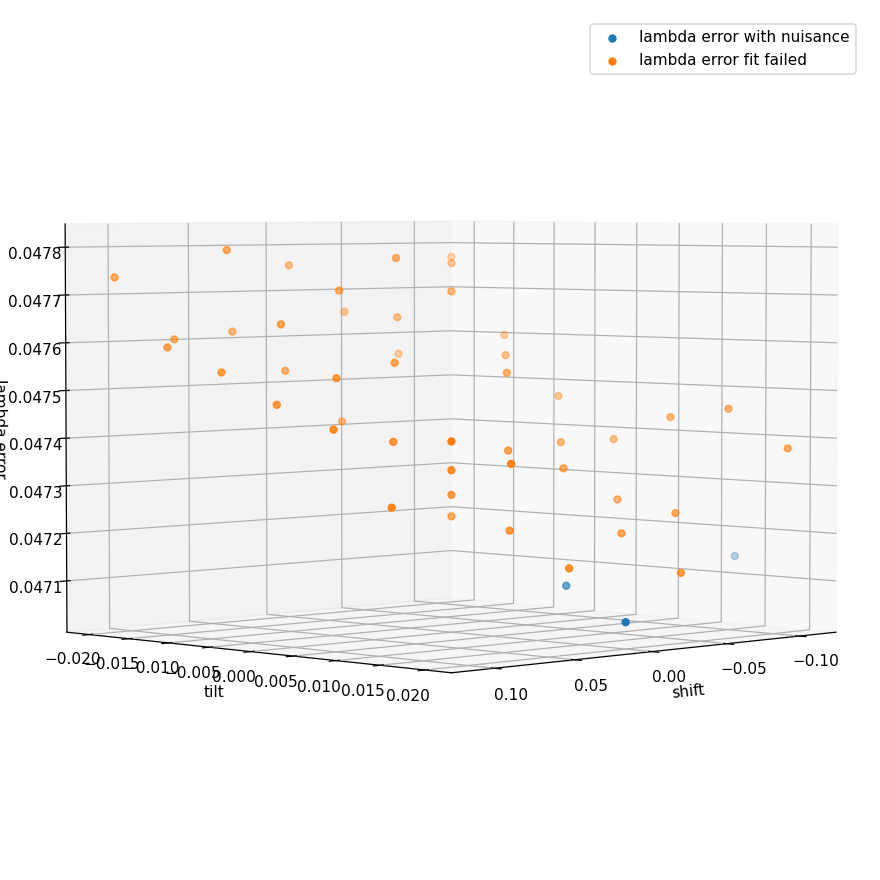

In [14]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_lambda_3d):
    ax.scatter3D(*zip(*errors_lambda_3d), label='lambda error with nuisance') 
if bool(errors_lambda_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*errors_lambda_3d_fail), label='lambda error fit failed', color='tab:orange')
ax.view_init(3,45)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('lambda error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_lambda_error_nuisance.pdf") 
plt.show()

<IPython.core.display.Javascript object>


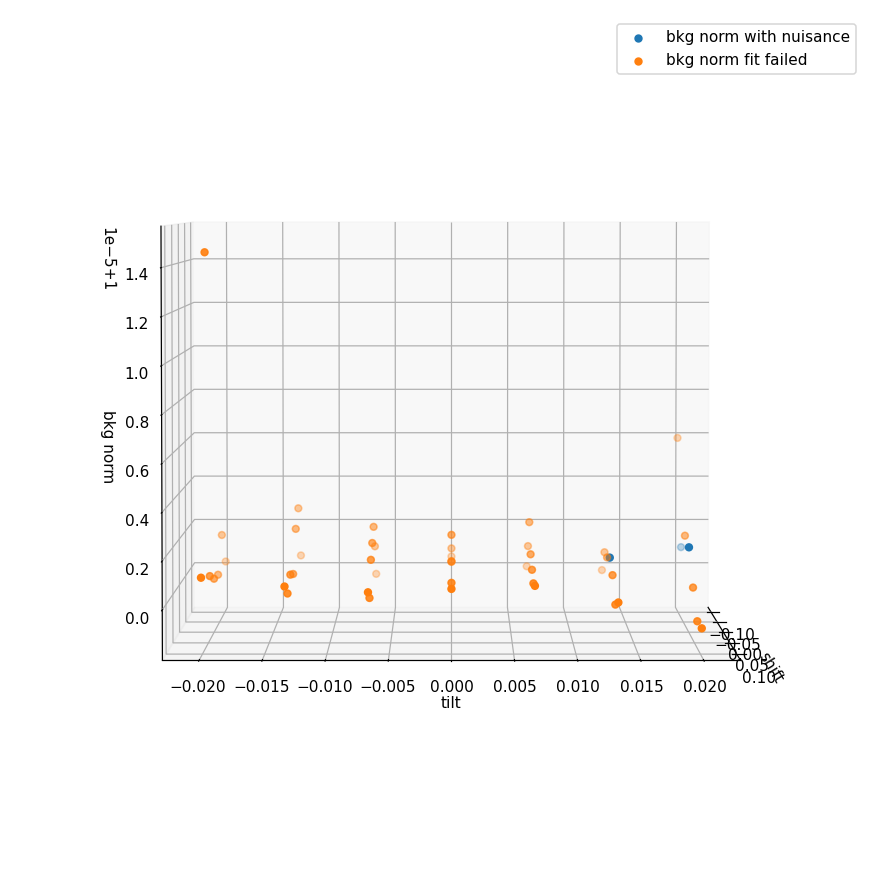

In [15]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_norm_3d):
    ax.scatter3D(*zip(*norm_3d), label='bkg norm with nuisance') 
if bool(errors_norm_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*norm_3d_fail), label='bkg norm fit failed', color='tab:orange') 
ax.view_init(3,0)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('bkg norm')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_norm_nuisance.pdf")
plt.show()

<IPython.core.display.Javascript object>


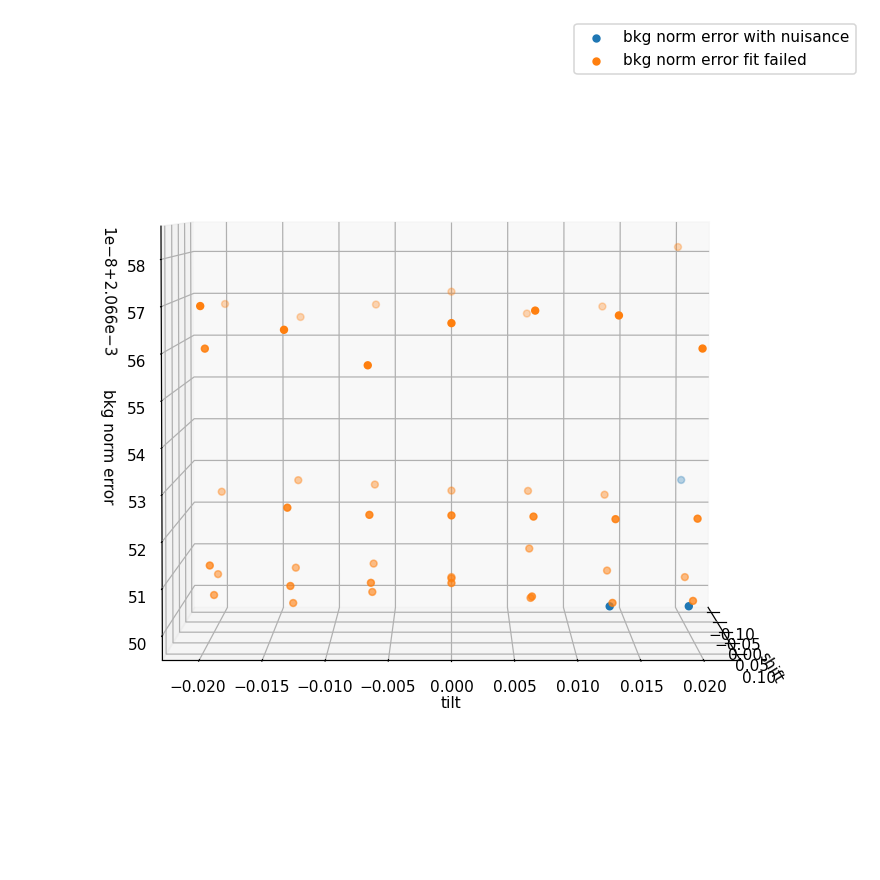

In [16]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_norm_3d):
    ax.scatter3D(*zip(*errors_norm_3d), label='bkg norm error with nuisance') 
if bool(errors_norm_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*errors_norm_3d_fail), label='bkg norm error fit failed', color='tab:orange')
ax.view_init(3,0)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('bkg norm error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_norm_error_nuisance.pdf") 
plt.show()

### Comparison with Best Fit

In [28]:
amplitude_3d_standard = np.loadtxt('data/1b_amplitude_3d.txt')
index_3d_standard = np.loadtxt('data/1b_index_3d.txt')
lambda_3d_standard = np.loadtxt('data/1b_lambda_3d.txt')
norm_3d_standard = np.loadtxt('data/1b_norm_3d.txt')
errors_amplitude_3d_standard = np.loadtxt('data/1b_errors_amplitude_3d.txt')
errors_index_3d_standard = np.loadtxt('data/1b_errors_index_3d.txt')
errors_lambda_3d_standard = np.loadtxt('data/1b_errors_lambda_3d.txt')
errors_norm_3d_standard = np.loadtxt('data/1b_errors_norm_3d.txt')

amplitude_3d_standard_fail = np.loadtxt('data/1b_amplitude_3d_fail.txt')
index_3d_standard_fail = np.loadtxt('data/1b_index_3d_fail.txt')
lambda_3d_standard_fail = np.loadtxt('data/1b_lambda_3d_fail.txt')
norm_3d_standard_fail = np.loadtxt('data/1b_norm_3d_fail.txt')
errors_amplitude_3d_standard_fail = np.loadtxt('data/1b_errors_amplitude_3d_fail.txt')
errors_index_3d_standard_fail = np.loadtxt('data/1b_errors_index_3d_fail.txt')
errors_lambda_3d_standard_fail = np.loadtxt('data/1b_errors_lambda_3d_fail.txt')
errors_norm_3d_standard_fail = np.loadtxt('data/1b_errors_norm_3d_fail.txt')

<IPython.core.display.Javascript object>


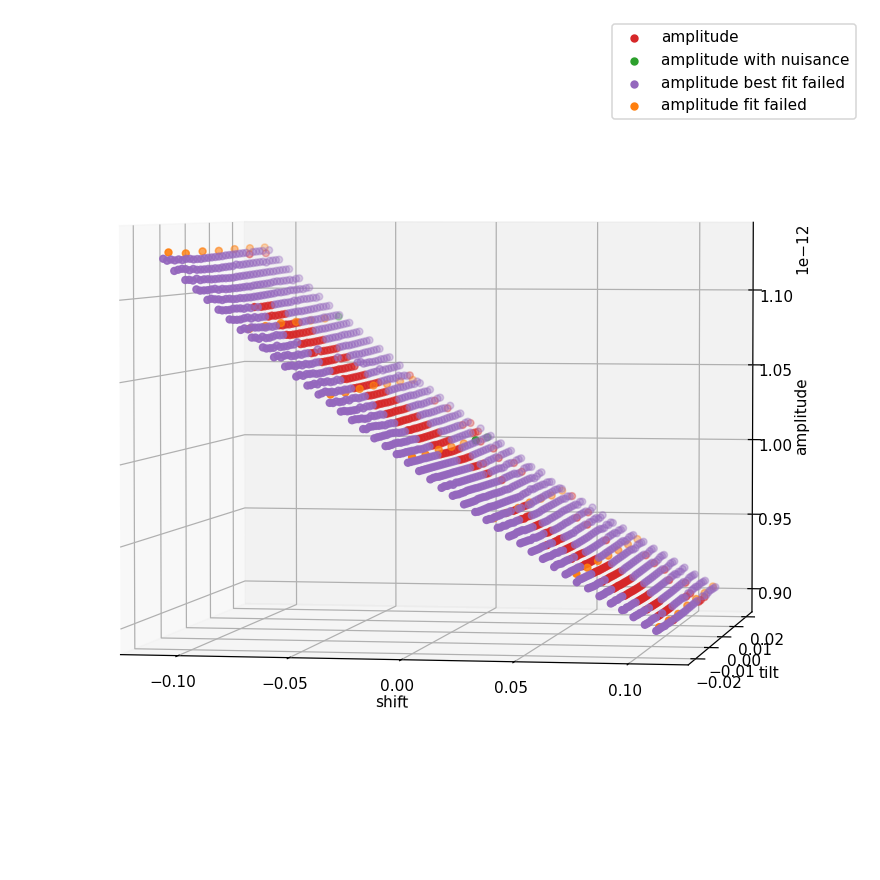

In [18]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')

if bool(errors_amplitude_3d):
    ax.scatter3D(*zip(*amplitude_3d_standard), label='amplitude', color = 'tab:red')
    ax.scatter3D(*zip(*amplitude_3d), label='amplitude with nuisance', color = 'tab:green')
if bool(errors_amplitude_3d_fail):#errors_amplitude_3d_fail.size > 0:
    ax.scatter3D(*zip(*amplitude_3d_standard_fail), label='amplitude best fit failed', color='tab:purple')
    ax.scatter3D(*zip(*amplitude_3d_fail), label='amplitude fit failed', color='tab:orange')
ax.view_init(3,280)
#ax.set_zlim3d(1.1e-13, 1.4e-13)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('amplitude')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_amplitude_comparison.pdf") 
plt.show()

<IPython.core.display.Javascript object>


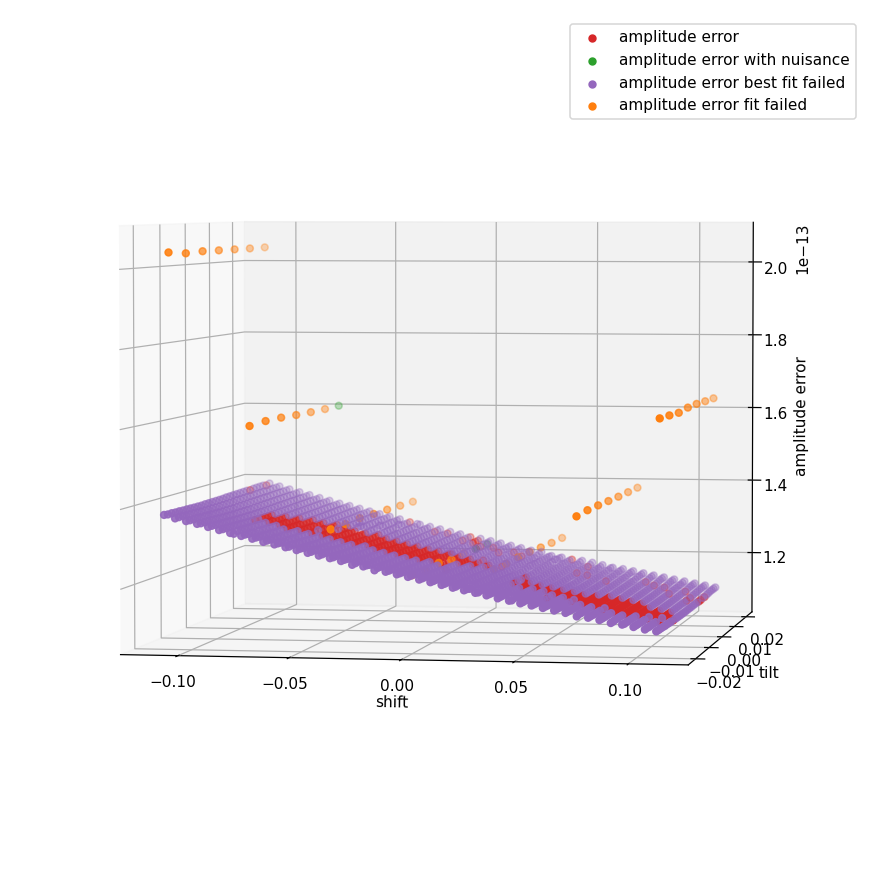

In [19]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')

if bool(errors_amplitude_3d):
    ax.scatter3D(*zip(*errors_amplitude_3d_standard), label='amplitude error', color = 'tab:red') 
    ax.scatter3D(*zip(*errors_amplitude_3d), label='amplitude error with nuisance', color = 'tab:green') 
if bool(errors_amplitude_3d_fail):#errors_amplitude_3d_fail.size > 0:
    ax.scatter3D(*zip(*errors_amplitude_3d_standard_fail), label='amplitude error best fit failed', color='tab:purple') 
    ax.scatter3D(*zip(*errors_amplitude_3d_fail), label='amplitude error fit failed', color='tab:orange')
ax.view_init(3,280)
#ax.set_zlim3d(1.1e-13, 1.4e-13)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('amplitude error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_amplitude_error_comparison.pdf") 
plt.show()

<IPython.core.display.Javascript object>


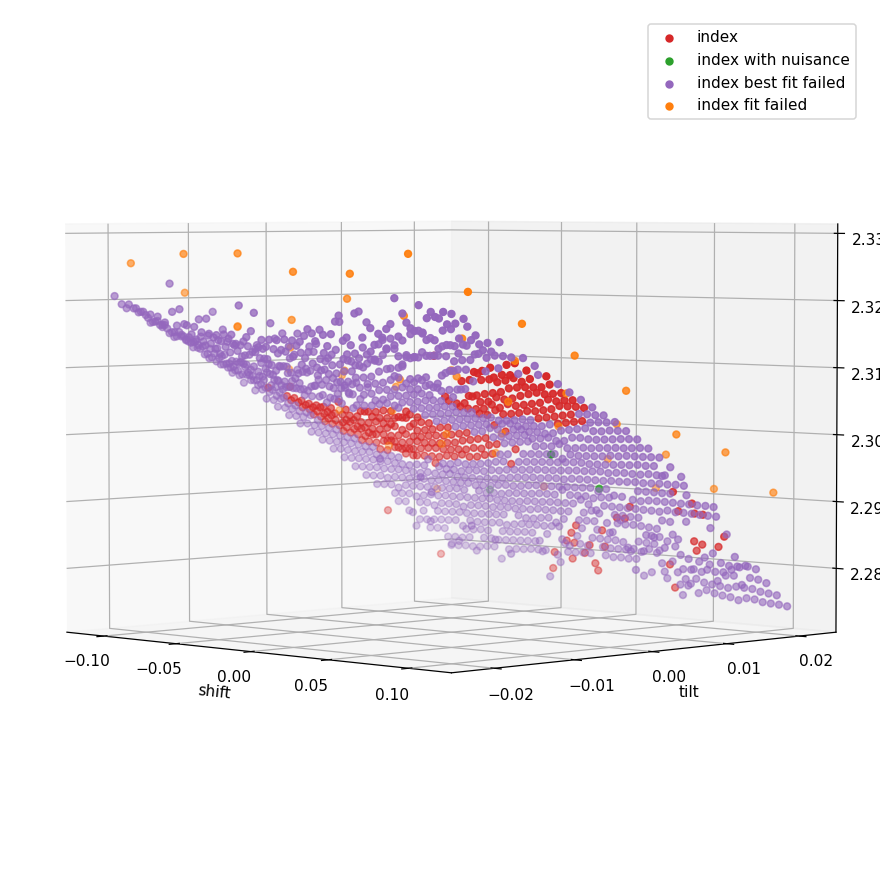

In [20]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_index_3d):
    ax.scatter3D(*zip(*index_3d_standard), label='index', color = 'tab:red') 
    ax.scatter3D(*zip(*index_3d), label='index with nuisance', color = 'tab:green') 
if bool(errors_index_3d_fail): #errors_index_3d_fail.size > 0:
    ax.scatter3D(*zip(*index_3d_standard_fail), label='index best fit failed', color='tab:purple') 
    ax.scatter3D(*zip(*index_3d_fail), label='index fit failed', color='tab:orange') 
ax.view_init(3,315)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('index')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_index_comparison.pdf") 
plt.show()

<IPython.core.display.Javascript object>


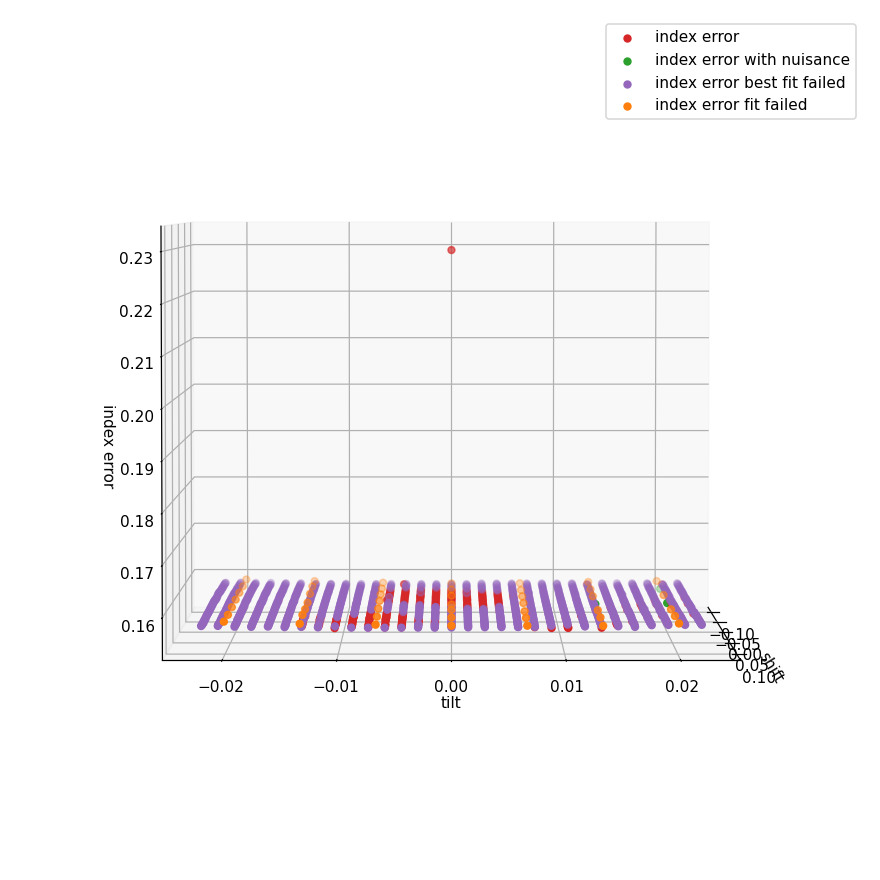

In [21]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_index_3d):
    ax.scatter3D(*zip(*errors_index_3d_standard), label='index error', color = 'tab:red') 
    ax.scatter3D(*zip(*errors_index_3d), label='index error with nuisance', color = 'tab:green') 
if bool(errors_index_3d_fail):#errors_index_3d_fail.size > 0:
    ax.scatter3D(*zip(*errors_index_3d_standard_fail), label='index error best fit failed', color='tab:purple') 
    ax.scatter3D(*zip(*errors_index_3d_fail), label='index error fit failed', color='tab:orange') 
ax.view_init(3,0)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('index error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_index_error_comparison.pdf") 
plt.show()

<IPython.core.display.Javascript object>


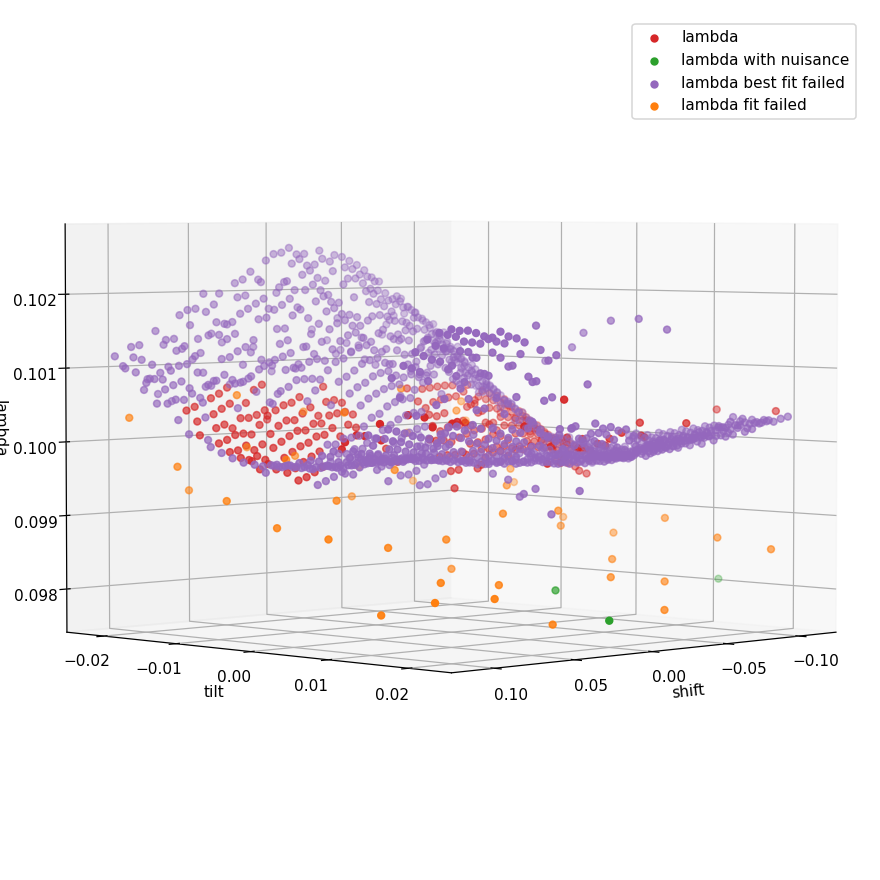

In [22]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_lambda_3d):
    ax.scatter3D(*zip(*lambda_3d_standard), label='lambda', color = 'tab:red')
    ax.scatter3D(*zip(*lambda_3d), label='lambda with nuisance', color = 'tab:green') 
if bool(errors_lambda_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*lambda_3d_standard_fail), label='lambda best fit failed', color='tab:purple')
    ax.scatter3D(*zip(*lambda_3d_fail), label='lambda fit failed', color='tab:orange')
ax.view_init(3,45)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('lambda')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_lambda_comparison.pdf") 
plt.show()

In [29]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_lambda_3d):
    ax.scatter3D(*zip(*errors_lambda_3d_standard), label='lambda error', color = 'tab:red')
    ax.scatter3D(*zip(*errors_lambda_3d), label='lambda error with nuisance', color = 'tab:green') 
if bool(errors_lambda_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*errors_lambda_3d_standard_fail), label='lambda error best fit failed', color='tab:purple')
    ax.scatter3D(*zip(*errors_lambda_3d_fail), label='lambda error fit failed', color='tab:orange')
ax.view_init(3,270)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('lambda error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_lambda_error_comparison.pdf") 
plt.show()

<IPython.core.display.Javascript object>


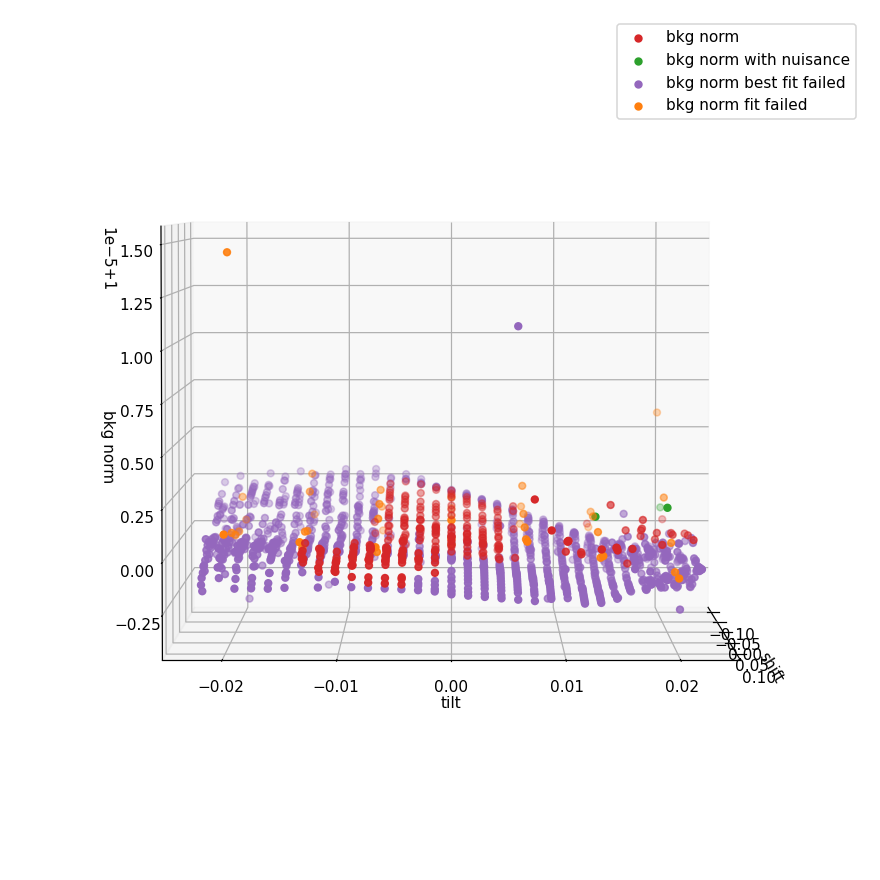

In [25]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_norm_3d):
    ax.scatter3D(*zip(*norm_3d_standard), label='bkg norm', color = 'tab:red')
    ax.scatter3D(*zip(*norm_3d), label='bkg norm with nuisance', color = 'tab:green') 
if bool(errors_norm_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*norm_3d_standard_fail), label='bkg norm best fit failed', color='tab:purple')
    ax.scatter3D(*zip(*norm_3d_fail), label='bkg norm fit failed', color='tab:orange') 
ax.view_init(3,0)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('bkg norm')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_norm_comparison.pdf")
plt.show()

<IPython.core.display.Javascript object>


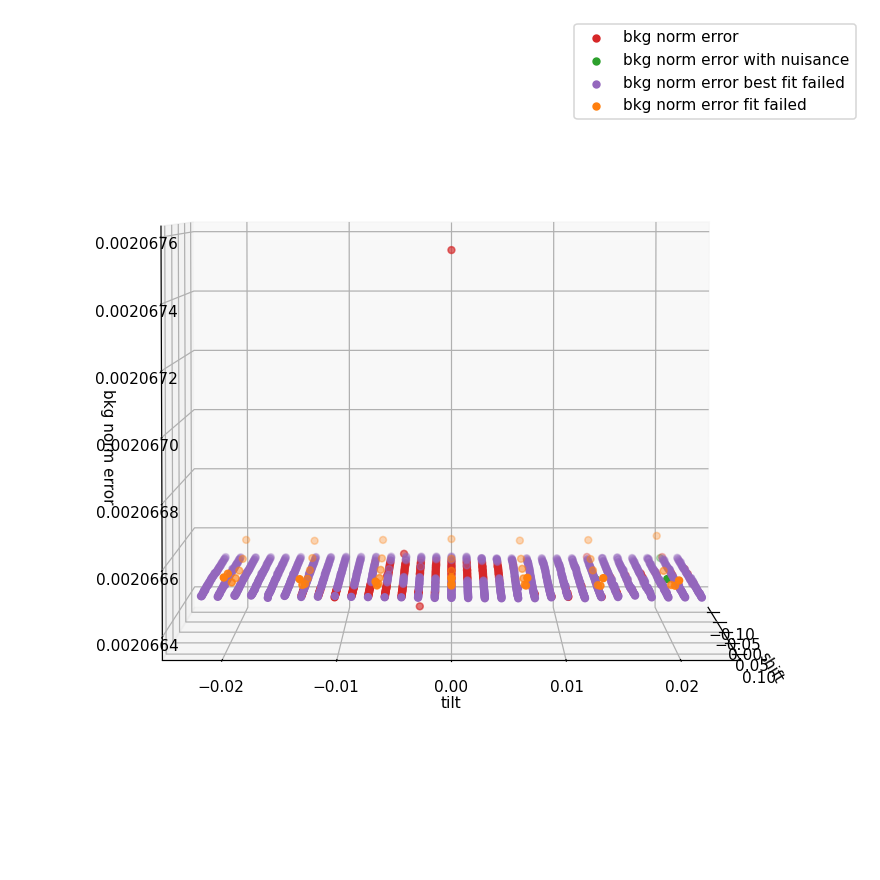

In [26]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

if bool(errors_norm_3d):
    ax.scatter3D(*zip(*errors_norm_3d_standard), label='bkg norm error', color = 'tab:red')
    ax.scatter3D(*zip(*errors_norm_3d), label='bkg norm error with nuisance', color = 'tab:green') 
if bool(errors_norm_3d_fail):#.size > 0:
    ax.scatter3D(*zip(*errors_norm_3d_standard_fail), label='bkg norm error best fit failed', color='tab:purple')
    ax.scatter3D(*zip(*errors_norm_3d_fail), label='bkg norm error fit failed', color='tab:orange')
ax.view_init(3,0)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('bkg norm error')
ax.legend()
plt.tight_layout()
fig.savefig("plots/2c_tilt_shift_norm_error_comparison.pdf") 
plt.show()

<IPython.core.display.Javascript object>


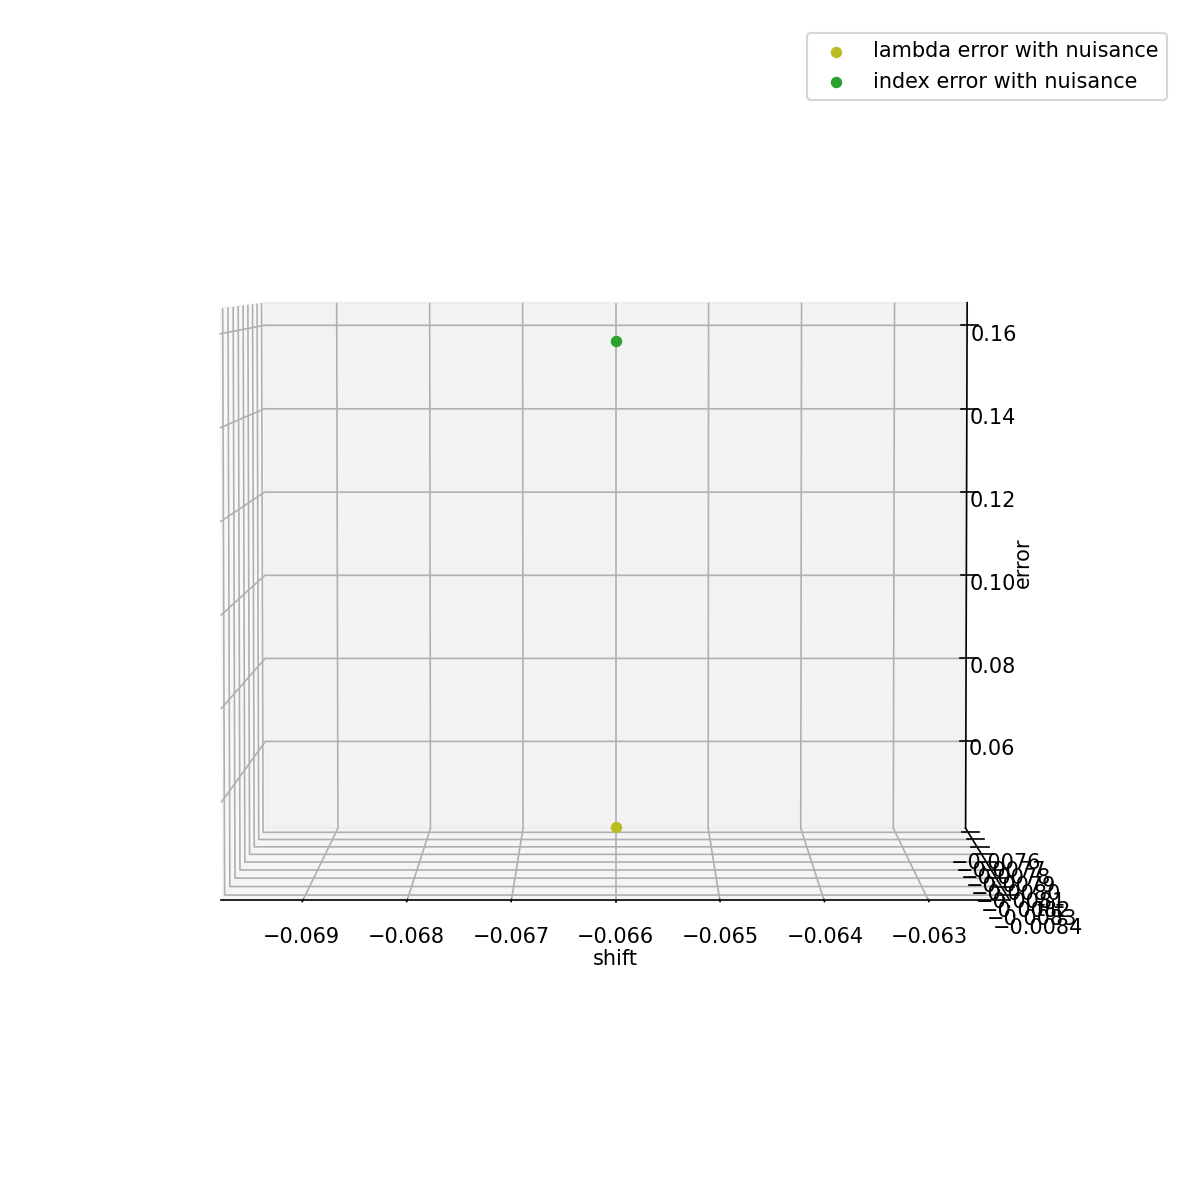

In [39]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

ax.scatter3D(*zip(*errors_lambda_3d), label='lambda error with nuisance', color = 'tab:olive')
ax.scatter3D(*zip(*errors_index_3d), label='index error with nuisance', color = 'tab:green') 
#ax.set_zlim3d(0.0465,0.0490)
ax.view_init(3,270)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('error')
ax.legend()
plt.tight_layout()
#fig.savefig("plots/2c_tilt_shift_norm_error_comparison.pdf") 
plt.show()